In [10]:
pip install quandl


In [0]:
import quandl
quandl.ApiConfig.api_key = "m_PhmAZJxm-Fw5QzRzfZ"
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

In [0]:
#get the stock data
data = quandl.get_table('WIKI/PRICES',
                        ticker='IBM', 
                        qopts={'columns':['date', 'open', 'high', 'low', 'close']},
                        paginate=True)

In [30]:

# Renaming the pandas dataframe columns
data.columns = ['Date', 'Open', 'High', 'Low', 'Close']

# Reset the pandas dataframe index
data = data.reset_index(drop=True)

# Show the last five rows of the pandas dataframe
data.tail()

,Date,Open,High,Low,Close
14150,1962-01-08,559.5,559.5,545.0,549.50
14151,1962-01-05,570.5,570.5,559.0,560.00
14152,1962-01-04,577.0,577.0,571.0,571.25
14153,1962-01-03,572.0,577.0,572.0,577.00
14154,1962-01-02,578.5,578.5,572.0,572.00


In [31]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
from bokeh.embed import components
from bokeh.io import output_notebook

print('Packages imported.')

Packages imported.


In [0]:

# Load bokeh
output_notebook()

In [0]:
# Bokeh Figure
p = figure(plot_width=1200, plot_height=550, title='Stock Value Historical Data', x_axis_type="datetime")

# Plot Lines
p.line(data.Date, data.Open, line_width=2, line_color="#0099ff", legend='Open')
p.line(data.Date, data.Close, line_width=2, line_color="#ff6699", legend='Close')
p.line(data.Date, data.High, line_width=1, line_color="#000000", legend='High')
p.line(data.Date, data.Low, line_width=1, line_color="#000000", legend='Low')

# Axis and Labels
p.legend.orientation = "vertical"
p.xaxis.axis_label = "Date"
p.xaxis.axis_label_text_font_style = 'bold'
p.xaxis.axis_label_text_font_size = '16pt'
p.xaxis.major_label_text_font_size = '14pt'
p.yaxis.axis_label = "Value ($ USD)"
p.yaxis.axis_label_text_font_style = 'bold'
p.yaxis.axis_label_text_font_size = '16pt'
p.yaxis.major_label_text_font_size = '12pt'

In [36]:

show(p)

In [47]:
pip install fbprophet

In [48]:
pip install pystan

In [49]:
from fbprophet import Prophet
import datetime as dt

print('Packages imported.')

Packages imported.


In [50]:
# Select train sample
df_train = data.copy()
df_train = df_train[(df_train.Date > dt.datetime(2008,1,1))]
df_train.tail()

,Date,Open,High,Low,Close
2571,2008-01-08,100.050,100.38,97.17,97.59
2572,2008-01-07,100.355,101.00,99.03,100.05
2573,2008-01-04,103.950,103.95,100.48,101.13
2574,2008-01-03,104.410,105.57,103.98,104.90
2575,2008-01-02,108.990,108.99,104.17,104.69


In [51]:
# Format the dataframe for FBProphet
df_train.rename(columns={'Open':'y', 'Date':'ds'}, inplace=True)
df_train = df_train.filter(items=['ds', 'y'])
df_train.tail()


,ds,y
2571,2008-01-08,100.050
2572,2008-01-07,100.355
2573,2008-01-04,103.950
2574,2008-01-03,104.410
2575,2008-01-02,108.990


In [52]:
# Instantiate a fbprophet model
model = Prophet(daily_seasonality=False,
                weekly_seasonality=False, 
                yearly_seasonality=True,
                changepoint_prior_scale=0.05,
                changepoints=None)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [53]:

# Train model
model.fit(df_train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [54]:
# Execute forecasting algorithm (1 year into the future)
future_data = model.make_future_dataframe(periods=365, freq='D')
future_data = model.predict(future_data)
future_data.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2936,2019-03-23,167.857700,147.057449,192.906404,146.574440,185.337887,3.307832,3.307832,3.307832,-0.303869,-0.303869,-0.303869,3.611701,3.611701,3.611701,0.0,0.0,0.0,171.165531
2937,2019-03-24,167.875086,146.997442,191.142374,146.507303,185.555093,3.488793,3.488793,3.488793,-0.324944,-0.324944,-0.324944,3.813737,3.813737,3.813737,0.0,0.0,0.0,171.363879
2938,2019-03-25,167.892472,148.833608,192.405559,146.392171,185.772299,3.891269,3.891269,3.891269,-0.118951,-0.118951,-0.118951,4.010220,4.010220,4.010220,0.0,0.0,0.0,171.783741
2939,2019-03-26,167.909858,147.611623,192.993536,146.306613,185.939143,4.279897,4.279897,4.279897,0.080996,0.080996,0.080996,4.198901,4.198901,4.198901,0.0,0.0,0.0,172.189755
2940,2019-03-27,167.927244,147.239601,191.280860,146.255840,186.048724,4.410317,4.410317,4.410317,0.032757,0.032757,0.032757,4.377559,4.377559,4.377559,0.0,0.0,0.0,172.337561


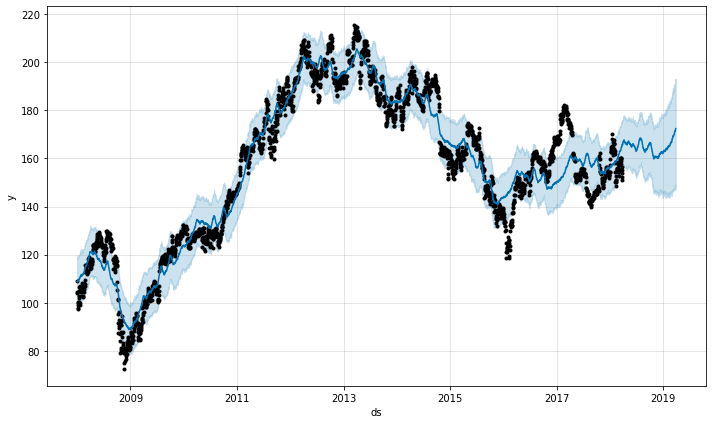

In [55]:
fig1 = model.plot(future_data)

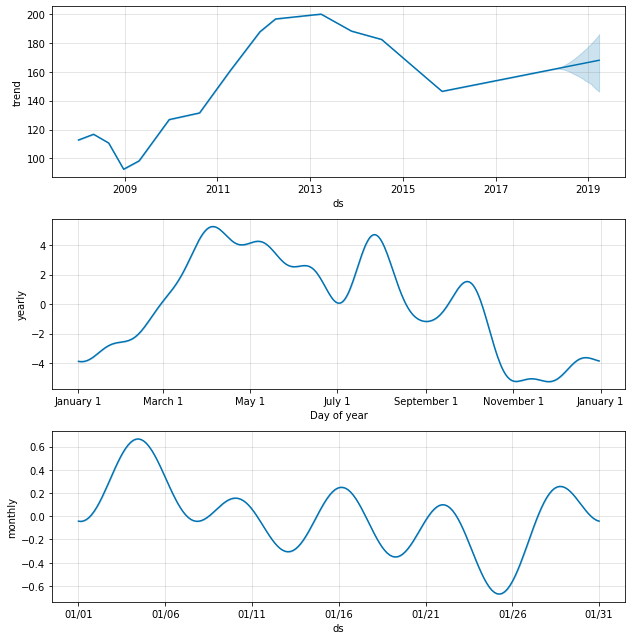

In [56]:
fig2 = model.plot_components(future_data)

In [0]:
# Bokeh Figure
p = figure(plot_width=1200, plot_height=550, title='Stock Value Historical Data', x_axis_type="datetime")

# Plot Lines
p.line(data[data['Date'] > dt.datetime(2008,1,1)].Date, data[data['Date'] > dt.datetime(2008,1,1)].Open, line_width=2, line_color="#0099ff", legend='Observed Open Value')
p.line(future_data.ds, future_data.yhat, line_width=2, line_color="#2B0000", legend='Modeled Open Value')
p.line(future_data.ds, future_data.yhat_upper, line_width=0.5, line_color="#000099", legend='Upper Estimates')
p.line(future_data.ds, future_data.yhat_lower, line_width=0.5, line_color="#000099", legend='Lower Estimates')

# Axis and Labels
p.legend.orientation = "vertical"
p.xaxis.axis_label = "Date"
p.xaxis.axis_label_text_font_style = 'bold'
p.xaxis.axis_label_text_font_size = '16pt'
p.xaxis.major_label_text_font_size = '14pt'
p.yaxis.axis_label = "Value ($ USD)"
p.yaxis.axis_label_text_font_style = 'bold'
p.yaxis.axis_label_text_font_size = '16pt'
p.yaxis.major_label_text_font_size = '12pt'

In [58]:
show(p)

In [59]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
df_cv.head()

INFO:fbprophet:Making 15 forecasts with cutoffs between 2010-05-03 00:00:00 and 2017-03-27 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-05-04,130.125353,126.853355,133.687169,128.89,2010-05-03
1,2010-05-05,129.849046,126.188489,133.431304,127.12,2010-05-03
2,2010-05-06,129.896752,126.367272,133.427186,126.29,2010-05-03
3,2010-05-07,130.086849,126.708939,133.478529,123.36,2010-05-03
4,2010-05-10,128.465632,124.959049,132.047277,126.27,2010-05-03


In [60]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,37 days,93.917284,9.691093,8.098506,0.048515,0.399325
1,38 days,94.464600,9.719290,8.116347,0.048627,0.401495
2,39 days,95.461931,9.770462,8.151825,0.048875,0.401254
3,40 days,98.132013,9.906160,8.275073,0.049647,0.393537
4,41 days,100.302406,10.015109,8.387325,0.050319,0.388594


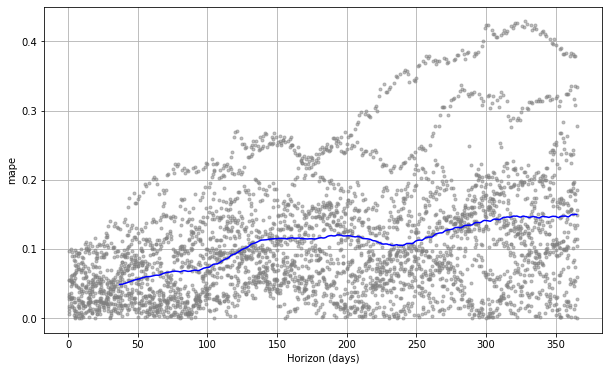

In [61]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


In [64]:
 pip install ibm-cos-sdk

     |████████████████████████████████| 61kB 4.1MB/s 
     |████████████████████████████████| 757kB 25.4MB/s 
     |████████████████████████████████| 225kB 42.0MB/s 
  Created wheel for ibm-cos-sdk: filename=ibm_cos_sdk-2.5.5-py2.py3-none-any.whl size=72186 sha256=f7f0a48017d4702263daf334cc3735319566e8db01626dde8d0c68de64e1efaa
  Stored in directory: /root/.cache/pip/wheels/4b/d1/47/7bfbd0c47216fbf180dd8e39df62499f26e0ef94100b5feb62
  Created wheel for ibm-cos-sdk-core: filename=ibm_cos_sdk_core-2.5.5-py2.py3-none-any.whl size=438519 sha256=09ce8886c3a3b8c952a84816c9820e3b68e894e1551403711231e98064474312
  Stored in directory: /root/.cache/pip/wheels/0e/f5/95/9c4a7d23860dc34fe0a49f2265b5259802d2ad72156fd9a6fe
  Created wheel for ibm-cos-sdk-s3transfer: filename=ibm_cos_sdk_s3transfer-2.5.5-py2.py3-none-any.whl size=89224 sha256=12f69e1bd114fae5d91aeb0812636be630c5febcdd20bb508fb916073a275ced
  Stored in directory: /root/.cache/pip/wheels/e9/80/1a/6bdcf3777571ab7a36539a65f0fc95c13d347a7

In [65]:
pip install pyinstaller

     |████████████████████████████████| 3.5MB 9.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyinstaller: filename=PyInstaller-3.5-cp36-none-any.whl size=2877897 sha256=633850cdcbe96c7d1970ec9b35b68ad1b8234db4a559f271b2e38e821ad1ce5f
  Stored in directory: /root/.cache/pip/wheels/c6/a4/e0/d9a1c5d3d876eb0675171281c293aed80839115e2eb022e6d2
Successfully built pyinstaller


In [66]:
from ibm_botocore.client import Config
import ibm_boto3, os

print('Packages imported.')

Packages imported.


In [0]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
cos_credentials = {
    'IAM_SERVICE_ID': '',
    'IBM_API_KEY_ID': '',
    'ENDPOINT': '',
    'IBM_AUTH_ENDPOINT': '',
    'BUCKET': '',
}

In [0]:
def upload_data_to_ibm_cos(credentials, df, df_future, tick):
    cos = ibm_boto3.client(service_name='s3', 
                           ibm_api_key_id=credentials['IBM_API_KEY_ID'], 
                           ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
                           ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
                           config=Config(signature_version='oauth'),
                           endpoint_url=credentials['ENDPOINT'])
    df.to_csv('{}.csv'.format(tick), sep=',', encoding='utf-8')
    df_future.to_csv('{}_future.csv'.format(tick), sep=',', encoding='utf-8')
    try:
        res=cos.upload_file(Filename='{}.csv'.format(tick), Bucket=credentials['BUCKET'], Key='{}.csv'.format(tick))
        res=cos.upload_file(Filename='{}_future.csv'.format(tick), Bucket=credentials['BUCKET'], Key='{}_future.csv'.format(tick))
    except Exception as e:
        print(Exception, e)
    else:
        print("{} data uploaded to IBM COS.".format(tick))
        os.remove('{}.csv'.format(tick))
        os.remove('{}_future.csv'.format(tick))

In [75]:
# Upload mined and modeled data to IBM COS
upload_data_to_ibm_cos(cos_credentials, data, future_data, 'IBM')

ValueError: ignored